# Vortex center glow

The aim of this simulation is to model the vortex center glow effect, which is caused to diffraction of the thermal emission from the environment outside the entrance pupil to the pupil image formed on the detector, by the vortex phase mask. 
To model the effect, several points outside the entrance pupil are taken and their intensity on the detector is evaluated. Net effect is determined by adding contributions from all these points.

### Imports

In [1]:
import heeps
from heeps.optics.lens import lens, lens_offset
from heeps.optics.vortex_init import vortex_init
from heeps.util.coord import cart_coord, polar_coord
from heeps.util.img_processing import resize_img, crop_img, pad_img, get_radial_profile
from heeps.optics import lyot_stop, detector
from copy import deepcopy
import proper
import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=200)
import os.path
from astropy.io import fits
import matplotlib.pyplot as plt
import multiprocessing as mpro
from functools import partial
from sys import platform
import time
%matplotlib inline

### Input parameters

In [2]:
diam_ext_eff = 8.1196
diam_int_eff = 1.293
diam_ext_cold_stop = diam_ext_eff*1.1048
diam_int_cold_stop = diam_int_eff-(diam_ext_eff*0.0999)
spi_angle = 50.5
r_spot = 0.04 # m
ncrop = 101 # for psf visualization
L_flux_env_per_m2 = 1.213e+03 # [photons/s/m2/pix]
L_flux_spi_per_m2 = 1.001e+03 # [photons/s/m2/pix]
L_flux_env = 3.3403e+05 # [photons/s/pix]
L_flux_spi = 0.4478e+05 # [photons/s/pix]
L_flux_std_bkgrd = 3.0747e+05 # [photons/s/pix]
N2_flux_env_per_m2 = 594.8e+03 # [photons/s/m2/pix]
N2_flux_spi_per_m2 = 494.3e+03 # [photons/s/m2/pix]
N2_flux_env = 3.3403e+05 # [photons/s/pix]
N2_flux_spi = 0.4478e+05 # [photons/s/pix]
N2_flux_std_bkgrd = 1.2821e+08 # [photons/s/pix]

### Initialize wavefront using PROPER

In [3]:
conf = dict(
#    dir_current = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/VCG',
    band = 'N2',
    mode = 'CVC',
    file_lyot_stop = 'pupil/ls_VCG_293.fits',
    dir_output = 'VCG_VISIR-VLT',
    cpu_count = None,
    hfov = 6,
    pupil_img_size = diam_ext_cold_stop + 2*r_spot,
    diam_ext = diam_ext_cold_stop, 
    diam_int = diam_int_cold_stop,
    spi_width = 0.04
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
dir_current = conf['dir_current']
dir_output = conf['dir_output']
npupil = conf['npupil']
ngrid = conf['ngrid']
diam_ext = conf['diam_ext']
diam_int = conf['diam_int']
pupil_img_size = conf['pupil_img_size']
lam = conf['lam']
pscale = conf['pscale']
spi_width = conf['spi_width']
ndet = conf['ndet']
cpu_count = conf['cpu_count']
beam_ratio = npupil/ngrid*(diam_ext/pupil_img_size)
wf = proper.prop_begin(pupil_img_size, lam, ngrid, beam_ratio)

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.1733
   npupil=179, pscale=45 mas, lam=1.1296E-05 m
   hfov=6.01 arcsec (-> ndet=267, 23.13 lam/D)



### Create VLT pupil

In [4]:
def create_pupil_VLT(pupil_img_size, diam_ext, diam_int, spi_width, npupil, nhr=2**10, **conf):
    # create a high res pupil with PROPER of even size (nhr)
    nhr = max(nhr, npupil)
    nhr += nhr % 2
    nhr_size = pupil_img_size*nhr/(nhr-1)
    # create pupil using PROPER tools
    wf_tmp = proper.prop_begin(nhr_size, 1, nhr, diam_ext/nhr_size) 
    if diam_ext > 0:
        proper.prop_circular_aperture(wf_tmp, 1, NORM=True)
    if diam_int > 0:
        proper.prop_circular_obscuration(wf_tmp, diam_int/diam_ext, NORM=True)
    if spi_width > 0:
        xd = 2.9109384641888396*2
        yd = 2.7469835168602827*2
        proper.prop_rectangular_obscuration(wf_tmp, 2*spi_width/diam_ext, 2, xc=xd/diam_ext, yc=-yd/diam_ext, ROTATION=90-spi_angle, NORM=True)
        proper.prop_rectangular_obscuration(wf_tmp, 2*spi_width/diam_ext, 2, xc=xd/diam_ext, yc=yd/diam_ext, ROTATION=90+spi_angle, NORM=True)
        proper.prop_rectangular_obscuration(wf_tmp, 2*spi_width/diam_ext, 2, xc=-xd/diam_ext, yc=yd/diam_ext, ROTATION=270-spi_angle, NORM=True)
        proper.prop_rectangular_obscuration(wf_tmp, 2*spi_width/diam_ext, 2, xc=-xd/diam_ext, yc=-yd/diam_ext, ROTATION=270+spi_angle, NORM=True)
    pup = proper.prop_get_amplitude(wf_tmp)
    # crop the pupil to odd size (nhr-1), and resize to npupil
    pup = pup[1:,1:]
    pup = resize_img(pup, npupil)
    return pup

### Create cold stop

(179, 179)


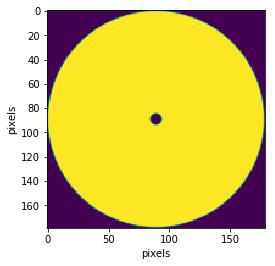

In [5]:
conf_stop = dict(conf, spi_width=0, seg_width=0)
cold_stop = create_pupil_VLT(**conf_stop)
print(cold_stop.shape)
plt.imshow(cold_stop), plt.xlabel('pixels'), plt.ylabel('pixels');
cold_stop = pad_img(cold_stop, ngrid)

### Create a spot, normalized by square meter of surface

In [6]:
def create_spot(rad, theta, nimg=10526):
    x, y = cart_coord(nimg)
    x *= pupil_img_size/2
    y *= pupil_img_size/2
    c = (rad*np.cos(np.deg2rad(theta)), rad*np.sin(np.deg2rad(theta)))
    r =  np.abs((x-c[0]) + 1j*(y-c[1]))
    spot = (r <= r_spot)                    # create a spot
    spot = resize_img(spot, npupil)         # resize to npupil
    spot = pad_img(spot, ngrid)             # pad with zeros
    # normalize the entrance pupil intensity (total flux = 1/spot_area)
    I_spot = spot**2
    spot_area = np.pi*r_spot**2
    spot = np.sqrt(I_spot/spot_area)
    return spot

def create_spot_spi(rad, theta, nimg=10526):
    x, y = cart_coord(nimg)
    x *= pupil_img_size/2
    y *= pupil_img_size/2
    if theta in [spi_angle, -spi_angle]:
        c = (diam_int_eff/2 + rad*np.cos(np.deg2rad(theta)), rad*np.sin(np.deg2rad(theta)))
    if theta in [180-spi_angle, 180+spi_angle]:
        c = (-diam_int_eff/2 + rad*np.cos(np.deg2rad(theta)), rad*np.sin(np.deg2rad(theta)))
    r =  np.abs((x-c[0]) + 1j*(y-c[1]))
    spot = (r <= r_spot)                    # create a spot
    spot = resize_img(spot, npupil)         # resize to npupil
    spot = pad_img(spot, ngrid)             # pad with zeros
    # normalize the entrance pupil intensity (total flux = 1/spot_area)
    I_spot = spot**2
    spot_area = np.pi*r_spot**2
    spot = np.sqrt(I_spot/spot_area)
    return spot

### Propagate functions

In [7]:
def fp_mask(wf, rad, mode='RAVC', focal=660, vc_zoffset=1e-3/2, verbose=False, **conf):
        if verbose is True:
            print('   apply vortex phase mask')                        
        # update conf
        conf.update(focal=focal)
        # propagate to vortex
        lens_offset(wf, focal, offset_after=vc_zoffset)
        # load vortex calibration files: psf_num, vvc, perf_num
        conf = vortex_init(verbose=verbose, **conf)
        # get maximum aplitude 
        amp_array = proper.prop_get_amplitude(wf)
        amp_max = np.amax(amp_array)
        #rescale flux
        if rad in r_int:
            proper.prop_multiply(wf, np.sqrt(N2_flux_env_per_m2)/amp_max)
        elif rad in r_ext:
            proper.prop_multiply(wf, np.sqrt(N2_flux_env_per_m2)/amp_max)
        elif rad in r_spi:
            proper.prop_multiply(wf, np.sqrt(N2_flux_spi_per_m2)/amp_max)
        # apply vortex
        scale_psf = wf._wfarr[0,0]/conf['psf_num'][0,0]
        wf_corr = (conf['psf_num']*conf['vvc'] - conf['perf_num'])*scale_psf
        wf._wfarr = wf._wfarr*conf['vvc'] - wf_corr
        # propagate to lyot stop
        lens_offset(wf, focal, offset_before=-vc_zoffset)
        return wf

In [8]:
def propag_one_spot(rad, theta, verbose=False):
        #print(rad, theta)
        # keep a copy of the input wavefront
        wf1 = deepcopy(wf)
        # create a normalized spot
        spot = create_spot(rad, theta)
        # add spot to wavefront
        proper.prop_multiply(wf1, spot)
        # apply cold stop
        proper.prop_multiply(wf1, cold_stop)
        # propagate one frame of onaxis psf (i.e. star)
        wf1 = fp_mask(wf1, rad, verbose=verbose, **conf)
        wf1 = lyot_stop(wf1, verbose=verbose, **conf)
        psf = detector(wf1, verbose=verbose, **conf)
        return psf
    
def propag_one_spot_spi(rad, theta, verbose=False):
        #print(rad, theta)
        # keep a copy of the input wavefront
        wf1 = deepcopy(wf)
        # create a normalized spot
        spot = create_spot_spi(rad, theta)
        # add spot to wavefront
        proper.prop_multiply(wf1, spot)
        # apply cold stop
        proper.prop_multiply(wf1, cold_stop)
        # propagate one frame of onaxis psf (i.e. star)
        wf1 = fp_mask(wf1, rad, verbose=verbose, **conf)
        wf1 = lyot_stop(wf1, verbose=verbose, **conf)
        psf = detector(wf1, verbose=verbose, **conf)
        return psf

In [9]:
def propag_multi_spots(rads, thetas, filename, cpu_count=cpu_count, verbose=False):
    nrads = len(rads)
    nthetas = len(thetas)
    print('radii = %s'%rads)
#    print('angles = %s'%thetas)
    if not os.path.isfile(filename):
        filename = os.path.join(dir_output, filename)
    try:
        cube = fits.getdata(filename)
        print('   Load cube from %s'%filename)
    except FileNotFoundError: # run simulation  
        cube = []
        t0 = time.time()
        if cpu_count != 1 and platform in ['linux', 'linux2', 'darwin']:
            if cpu_count == None:
                cpu_count = mpro.cpu_count() - 1
            print('   %s: VCG simulation starts, using %s cores'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), cpu_count))
            p = mpro.Pool(cpu_count)
            func = partial(propag_one_spot, verbose=verbose)
            func_spi = partial(propag_one_spot_spi, verbose=verbose)
            if rads in r_int:
                cube = np.array(p.starmap(func, zip(np.repeat(rads, nthetas), np.tile(thetas, nrads))))
            elif rads in r_ext:
                cube = np.array(p.starmap(func, zip(np.repeat(rads, nthetas), np.tile(thetas, nrads))))
            elif rads in r_spi:
                cube = np.array(p.starmap(func_spi, zip(np.repeat(rads, nthetas), np.tile(thetas, nrads))))
            p.close()
            p.join()
        else:
            print('   %s: VCG simulation starts, using 1 core'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
            for rad in all_rads and theta in all_thetas:
                cube.append(propag_one_spot(rad, theta, verbose=verbose))
        print('   %s: finished, elapsed %.3f seconds'\
            %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), time.time() - t0))
        fits.writeto(os.path.join(dir_output, filename), np.float32(cube), overwrite=True)
    return np.array(cube)

### VCG from points inside central obscuration

In [10]:
print('range = [%s, %s]'%(diam_int_eff/2, diam_int_cold_stop/2))
r_int = np.arange(diam_int_eff/2 - r_spot, diam_int_cold_stop/2 - r_spot, -2*r_spot)
t_int = np.arange(0, 360, 10)
cube = propag_multi_spots(r_int, t_int, 'cube_int.fits')

range = [0.6465, 0.24092597999999993]
radii = [0.6065 0.5265 0.4465 0.3665 0.2865 0.2065]
   Load cube from /mnt/disk4tb/Users/mshinde/HEEPS_26Mar2021/VCG_VISIR-VLT/cube_int.fits


I_int = 7.70E+07 photons/s
I_int_avg = 1.08E+03 photons/s/pix


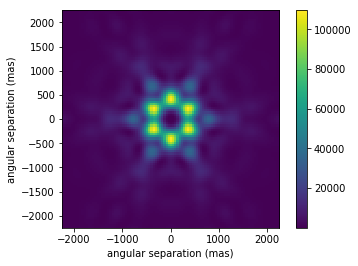

In [11]:
# normalize psf
psf_r_int = []
for i,r in enumerate(r_int):
    psf_r_int.append(np.sum(x*4*np.pi*r*r_spot/len(t_int) for x in cube[i*len(t_int):(i+1)*len(t_int)]))
I_r_int = np.sum((psf_r_int), (1,2))
psf_int = np.sum(psf_r_int, 0)
fits.writeto(os.path.join(dir_output, 'psf_int.fits'), np.float32(psf_int), overwrite=True)
rad_int = get_radial_profile(psf_int, (int(ndet/2), int(ndet/2)), 1)
I_int = np.sum(psf_int)
pix_tot = np.shape(psf_int)[0]*np.shape(psf_int)[1]
print('I_int = %s photons/s'%"{:.2E}".format(I_int))
print('I_int_avg = %s photons/s/pix'%"{:.2E}".format(float(I_int/pix_tot)))
lim = int(ncrop/2)*pscale
plt.imshow(crop_img(psf_int, ncrop), origin=True, extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### VCG from points beyond ELT pupil's outer edge

In [12]:
print('range = [%s, %s]'%(diam_ext_eff/2, diam_ext_cold_stop/2))
r_ext = np.arange(diam_ext_eff/2 + r_spot, diam_ext_cold_stop/2 + r_spot, 2*r_spot)
t_ext = np.arange(0, 360, 5)
cube = propag_multi_spots(r_ext, t_ext, 'cube_ext.fits')

range = [4.0598, 4.48526704]
radii = [4.0998 4.1798 4.2598 4.3398 4.4198 4.4998]
   Load cube from /mnt/disk4tb/Users/mshinde/HEEPS_26Mar2021/VCG_VISIR-VLT/cube_ext.fits


I_ext = 1.01E+10 photons/s
I_ext_avg = 1.41E+05 photons/s/pix


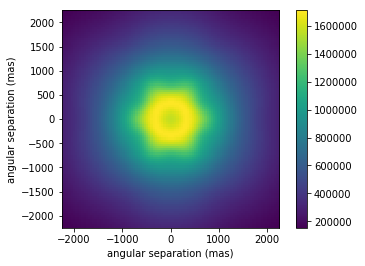

In [13]:
# normalize psf
psf_r_ext = []
for i,r in enumerate(r_ext):
    psf_r_ext.append(np.sum(x*4*np.pi*r*r_spot/len(t_ext) for x in cube[i*len(t_ext):(i+1)*len(t_ext)]))
I_r_ext = np.sum((psf_r_ext), (1,2))
psf_ext = np.sum(psf_r_ext, 0)
fits.writeto(os.path.join(dir_output, 'psf_ext.fits'), np.float32(psf_ext), overwrite=True)
rad_ext = get_radial_profile(psf_ext, (int(ndet/2), int(ndet/2)), 1)
I_ext = np.sum(psf_ext)
pix_tot = np.shape(psf_ext)[0]*np.shape(psf_ext)[1]
print('I_ext = %s photons/s'%"{:.2E}".format(I_ext))
print('I_ext_avg = %s photons/s/pix'%"{:.2E}".format(float(I_ext/pix_tot)))
plt.imshow(crop_img(psf_ext, ncrop), origin=True, extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### VCG from points along spiders

In [14]:
print('range = [%s, %s]'%(r_spot, 3.64 - r_spot))
r_spi = np.arange(r_spot, 3.64 - r_spot, 2*r_spot)
t_spi = [spi_angle, -spi_angle, 180-spi_angle, 180+spi_angle]
cube = propag_multi_spots(r_spi, t_spi, 'cube_spi.fits')

range = [0.04, 3.6]
radii = [0.04 0.12 0.2  0.28 0.36 0.44 0.52 0.6  0.68 0.76 0.84 0.92 1.   1.08 1.16 1.24 1.32 1.4  1.48 1.56 1.64 1.72 1.8  1.88 1.96 2.04 2.12 2.2  2.28 2.36 2.44 2.52 2.6  2.68 2.76 2.84 2.92 3.   3.08
 3.16 3.24 3.32 3.4  3.48 3.56]
   Load cube from /mnt/disk4tb/Users/mshinde/HEEPS_26Mar2021/VCG_VISIR-VLT/cube_spi.fits


I_spi = 2.18E+09 photons/s
I_spi_avg = 3.06E+04 photons/s/pix


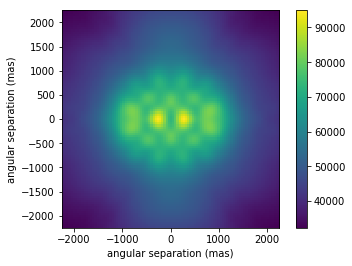

In [15]:
# normalize psf
psf_r_spi = []
for i,r in enumerate(r_spi):
    psf_r_spi.append(np.sum(x*2*spi_width*r_spot for x in cube[i*len(t_spi):(i+1)*len(t_spi)]))
I_r_spi = np.sum((psf_r_spi), (1,2))
psf_spi = np.sum(psf_r_spi, 0)
fits.writeto(os.path.join(dir_output, 'psf_spi.fits'), np.float32(psf_spi), overwrite=True)
rad_spi = get_radial_profile(psf_spi, (int(ndet/2), int(ndet/2)), 1)
I_spi = np.sum(psf_spi)
pix_tot = np.shape(psf_spi)[0]*np.shape(psf_spi)[1]
print('I_spi = %s photons/s'%"{:.2E}".format(I_spi))
print('I_spi_avg = %s photons/s/pix'%"{:.2E}".format(float(I_spi/pix_tot)))
lim = int(ncrop/2)*pscale
plt.imshow(crop_img(psf_spi, ncrop), origin=True, extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### Total VCG from all sources: int + ext + spi

I_all = 1.23E+10 photons/s
I_max_pix = 1.89E+06 photons/s/pix
I_avg = 1.73E+05 photons/s/pix


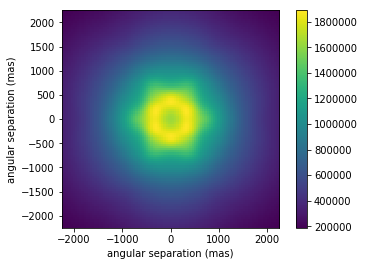

In [16]:
psf_all = psf_int + psf_ext + psf_spi
fits.writeto(os.path.join(dir_output, 'psf_all.fits'), np.float32(psf_all), overwrite=True)
rad_all = get_radial_profile(psf_all, (int(ndet/2), int(ndet/2)), 1)
I_all = np.sum(psf_all)
I_max_pix = np.amax(psf_all)
pix_tot = np.shape(psf_all)[0] * np.shape(psf_all)[1]
print('I_all = %s photons/s'%"{:.2E}".format(I_all))
print('I_max_pix = %s photons/s/pix'%"{:.2E}".format(I_max_pix))
print('I_avg = %s photons/s/pix'%"{:.2E}".format(float(I_all/pix_tot)))
plt.imshow(crop_img(psf_all, ncrop), origin=True, extent=[-lim, lim, -lim, lim])
plt.xlabel('angular separation (mas)'), plt.ylabel('angular separation (mas)'), plt.colorbar();

### Radial profile

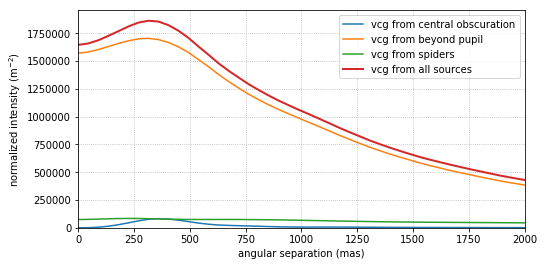

In [17]:
x = np.arange(rad_all.shape[0])*pscale
plt.figure(figsize=(8,4))
plt.plot(x, rad_int, label='vcg from central obscuration')
plt.plot(x, rad_ext, label='vcg from beyond pupil')
plt.plot(x, rad_spi, label='vcg from spiders')
plt.plot(x, rad_all, label='vcg from all sources', linewidth=2)
plt.xlabel('angular separation (mas)'), plt.ylabel('normalized intensity (m$^{-2})$')
plt.xlim(0, 2000), plt.ylim(bottom=0), plt.legend()
plt.grid(True, linestyle=':')
plt.savefig(os.path.join(dir_output, 'vcg_radial_profile.png'), dpi=300, transparent=True);

### Distribution of spots

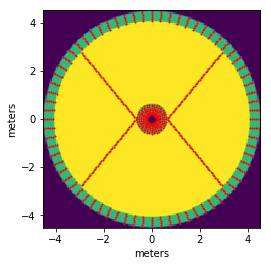

In [19]:
conf_pup = dict(conf, seg_width=0, diam_ext=diam_ext_eff, diam_int=diam_int_eff)
pup = create_pupil_VLT(**conf_pup)
lim = pupil_img_size/2
plt.imshow(crop_img(cold_stop, 179) + pup/2, origin=True, extent=[-lim, lim, -lim, lim])
rs = np.concatenate((np.repeat(r_int, len(t_int)), np.repeat(r_ext, len(t_ext))))
ts = np.concatenate((np.tile(t_int, len(r_int)), np.tile(t_ext, len(r_ext))))
xs = rs * np.cos(np.deg2rad(ts))
ys = rs * np.sin(np.deg2rad(ts))
plt.scatter(xs, ys, 1, color='r'), plt.xlabel('meters'), plt.ylabel('meters');
for theta in t_spi[0:2]:
    plt.scatter(r_spi*np.cos(np.deg2rad(theta)) + diam_int_eff/2, r_spi*np.sin(np.deg2rad(theta)), 1, color='r')
for theta in t_spi[2:4]:
    plt.scatter(r_spi*np.cos(np.deg2rad(theta)) - diam_int_eff/2, r_spi*np.sin(np.deg2rad(theta)), 1, color='r')

## Results

In [ ]:
I_int = 7.70E+07 photons/s
I_ext = 1.01E+10 photons/s
I_spi = 2.18E+09 photons/s
I_all = 1.23E+10 photons/s
I_int_avg = 1.08E+03 photons/s/pix
I_ext_avg = 1.41E+05 photons/s/pix
I_spi_avg = 3.06E+04 photons/s/pix
I_max_pix = 1.89E+06 photons/s/pix
I_avg = 1.73E+05 photons/s/pix